**Set up environment:**

Connect sqllite3 dataset to Python


In [1]:
import sqlite3
con=sqlite3.connect("./Sample Data.sqlite")
import pandas as pd
account=pd.read_sql("Select * from account",con)
account_date_session=pd.read_sql("Select * from account_date_session",con)
iap_purchase=pd.read_sql("Select * from iap_purchase",con)

Check table

In [2]:
account
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112792 entries, 0 to 112791
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   account_id            112792 non-null  object
 1   created_time          112792 non-null  object
 2   created_device        112792 non-null  object
 3   created_platform      112792 non-null  object
 4   country_code          112685 non-null  object
 5   created_app_store_id  112792 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 5.2+ MB


In [3]:
account_date_session
account_date_session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698974 entries, 0 to 1698973
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   account_id            object
 1   date                  object
 2   session_count         int64 
 3   session_duration_sec  int64 
dtypes: int64(2), object(2)
memory usage: 51.8+ MB


In [4]:
iap_purchase
iap_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           9909 non-null   object
 1   created_time         9909 non-null   object
 2   package_id_hash      9909 non-null   object
 3   iap_price_usd_cents  9909 non-null   int64 
 4   app_store_id         9909 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 387.2+ KB


Join 3 tables to 1 overview table by 

join account.account_id=account_date_session.account_id

account_date_session.account_id=iap_purchase.account_id and created_time group by account id

In [5]:
# Change date time and Group_by on iap_purchase table
import datetime as dt
import numpy as np
account_date_session['time']=pd.to_datetime(account_date_session['date'])
account_date_session['date_new']=account_date_session['time'].dt.date
iap_purchase['time'] = pd.to_datetime(iap_purchase['created_time'])
iap_purchase['date_new'] = iap_purchase['time'].dt.date
iap_purchase_sum = iap_purchase.groupby(['account_id','date_new'],as_index=False)['iap_price_usd_cents'].sum()
# iap_purchase_filter=iap_purchase_sum['iap_price_usd_cents'].notnull()
# iap_purchase_sum[iap_purchase_filter]
# iap_purchase_sum.info()
# Join 3 table and update month column for visualize
Overview_table_raw = pd.merge(account_date_session, account[['account_id','created_time','created_platform','country_code']], how='left', on=['account_id']) .merge(iap_purchase_sum[['account_id','date_new','iap_price_usd_cents']], how='left',on=['account_id','date_new'])
# Overview_table_raw['iap_price_usd_cents'] = Overview_table_raw['iap_price_usd_cents'].fillna(0)
# Overview_table_raw['Month'] = pd.to_datetime(Overview_table_raw['time']).dt.month
# Overview_table_raw['iap_price_usd_cents'] = (Overview_table_raw['iap_price_usd_cents']/100).round(2)
# Overview_table_raw

Check iap_price_usd_cents null data from overview_table_Raw after joining with iap_purchase_sum table


In [6]:
iap_purchase_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7299 entries, 0 to 7298
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           7299 non-null   object
 1   date_new             7299 non-null   object
 2   iap_price_usd_cents  7299 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 171.2+ KB


In [7]:
Overview_table_notnull=Overview_table_raw['iap_price_usd_cents'].notnull()
check=Overview_table_raw[Overview_table_notnull]
check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7292 entries, 458 to 1698744
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   account_id            7292 non-null   object        
 1   date                  7292 non-null   object        
 2   session_count         7292 non-null   int64         
 3   session_duration_sec  7292 non-null   int64         
 4   time                  7292 non-null   datetime64[ns]
 5   date_new              7292 non-null   object        
 6   created_time          7292 non-null   object        
 7   created_platform      7292 non-null   object        
 8   country_code          7284 non-null   object        
 9   iap_price_usd_cents   7292 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 626.7+ KB


7 row is missing from iap_price_usd_cents on Overview_table_Raw compare to iap_purchase_Sum

So we will join the table with null value with iap_purchase_sum then filter the list of missing data


In [8]:

check_null=pd.merge(iap_purchase_sum,check[['account_id','date_new','session_count']],how='left',on=['account_id','date_new'])
check_miss_null=check_null['session_count'].isna()
check_null[check_miss_null]


,account_id,date_new,iap_price_usd_cents,session_count
27,12348106,2016-01-04,369,NaN
1344,21488430788,2016-04-20,184,NaN
4532,47260381398,2016-10-15,553,NaN
4868,51553107104,2016-05-20,553,NaN
5012,51555496729,2016-12-25,184,NaN
5173,55846501230,2016-01-26,369,NaN
6546,68732700352,2016-04-24,184,NaN


Fill null with 0 for iap_price_usd_cents on Overview_table_raw

In [9]:
Overview_table_raw['iap_price_usd_cents'] = Overview_table_raw['iap_price_usd_cents'].fillna(0)
Overview_table_raw['Month'] = pd.to_datetime(Overview_table_raw['time']).dt.month
Overview_table_raw['iap_price_usd_cents'] = (Overview_table_raw['iap_price_usd_cents']/100).round(2)
Overview_table_raw

,account_id,date,session_count,session_duration_sec,time,date_new,created_time,created_platform,country_code,iap_price_usd_cents,Month
0,68730811144,2016-01-01,1,47,2016-01-01,2016-01-01,2016-01-01 03:59:52.347,Android,US,0.0,1
1,68730812806,2016-01-01,1,204,2016-01-01,2016-01-01,2016-01-01 05:15:58.094,Android,US,0.0,1
2,68730829426,2016-01-01,12,4703,2016-01-01,2016-01-01,2016-01-01 15:52:35.871,Android,CO,0.0,1
3,68730829426,2016-01-02,9,4676,2016-01-02,2016-01-02,2016-01-01 15:52:35.871,Android,CO,0.0,1
4,68730829426,2016-01-03,9,2271,2016-01-03,2016-01-03,2016-01-01 15:52:35.871,Android,CO,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1698969,55850490316,2016-12-30,1,392,2016-12-30,2016-12-30,2016-12-28 16:38:22.758,Android,TR,0.0,12
1698970,55850515956,2016-12-30,1,564,2016-12-30,2016-12-30,2016-12-30 19:16:19.248,Android,TR,0.0,12
1698971,55850515956,2016-12-31,9,3268,2016-12-31,2016-12-31,2016-12-30 19:16:19.248,Android,TR,0.0,12
1698972,55850519336,2016-12-31,9,4043,2016-12-31,2016-12-31,2016-12-31 02:41:55.266,iOS,CN,0.0,12


Drop data from iap_purchase

In [10]:


iap_purchase_drop = iap_purchase.drop(iap_purchase[(iap_purchase['account_id'] == '12348106') & (iap_purchase['date_new'] == dt.date(2016,1,4)) 
                                                   | (iap_purchase['account_id'] == '21488430788') & (iap_purchase['date_new'] == dt.date(2016,4,20))
                                                   | (iap_purchase['account_id'] == '47260381398') & (iap_purchase['date_new'] == dt.date(2016,10,15))
                                                   | (iap_purchase['account_id'] == '51553107104') & (iap_purchase['date_new'] == dt.date(2016,5,20))
                                                   | (iap_purchase['account_id'] == '51555496729') & (iap_purchase['date_new'] == dt.date(2016,12,25))
                                                   | (iap_purchase['account_id'] == '55846501230') & (iap_purchase['date_new'] == dt.date(2016,1,26))
                                                   | (iap_purchase['account_id'] == '68732700352') & (iap_purchase['date_new'] == dt.date(2016,4,24))
                                                  ].index)
iap_purchase_drop['iap_price_usd_cents'] = (iap_purchase_drop['iap_price_usd_cents']/100).round(2)
iap_purchase_drop


,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id,time,date_new
0,30077202816,2016-03-26 23:59:59.355,ae0253c27c34edd1ab4fe21d6bfc91f8,7.39,0,2016-03-26 23:59:59.355,2016-03-26
1,30077202816,2016-05-31 11:24:37.283,dd4c1bda4f2c904075fb2fbfcf30f30e,3.69,0,2016-05-31 11:24:37.283,2016-05-31
2,21487283560,2016-02-13 03:40:28.644,99a9e0e63efa2fdce8fc8de74c66cea9,1.84,0,2016-02-13 03:40:28.644,2016-02-13
3,21487152816,2016-02-28 00:53:26.678,99a9e0e63efa2fdce8fc8de74c66cea9,1.84,0,2016-02-28 00:53:26.678,2016-02-28
4,8602037685,2016-02-11 01:03:04.727,99a9e0e63efa2fdce8fc8de74c66cea9,1.84,0,2016-02-11 01:03:04.727,2016-02-11
...,...,...,...,...,...,...,...
9904,51552698769,2016-07-23 03:25:58.87,99a9e0e63efa2fdce8fc8de74c66cea9,1.84,1,2016-07-23 03:25:58.870,2016-07-23
9905,51552698769,2016-07-25 05:57:33.827,99a9e0e63efa2fdce8fc8de74c66cea9,1.84,1,2016-07-25 05:57:33.827,2016-07-25
9906,51552698769,2016-11-14 01:01:11.202,efd2eebfdc98b55f9e6b45915d56f7ac,0.36,1,2016-11-14 01:01:11.202,2016-11-14
9907,51552698769,2016-12-02 13:43:30.761,efd2eebfdc98b55f9e6b45915d56f7ac,0.36,1,2016-12-02 13:43:30.761,2016-12-02


**Warm up question:**

Revenue picked and for this question i will focus on revenue part

Overview revenue trend with transaction and time per session

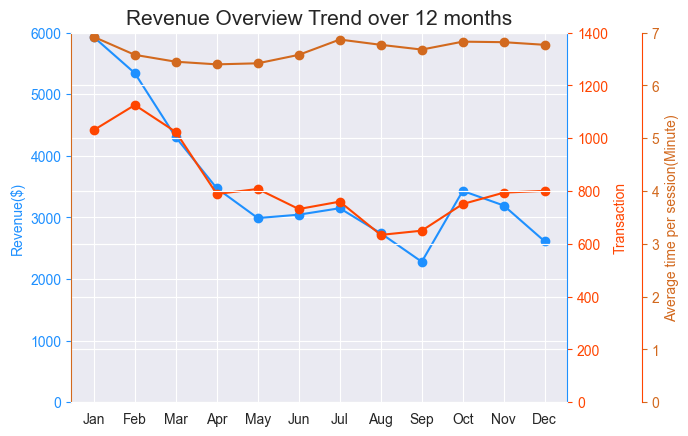

In [11]:
#Import package
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
#Rev calculate
Overview_table_rev_month = Overview_table_raw.groupby(['Month'],as_index=False)['iap_price_usd_cents'].sum()
Overview_table_rev_month=Overview_table_rev_month.sort_values(by=['Month'])
Overview_table_rev_month['Month'] = pd.to_datetime(Overview_table_rev_month['Month'], format='%m').dt.month_name().str.slice(stop=3)
#Time perssion calculate
def time_per_ss(sub_columns):
 return (sub_columns['session_duration_sec'].sum() / sub_columns['session_count'].sum()).round(0)
Overview_table_time_per_ss = (Overview_table_raw.groupby(['Month'],as_index=False).apply(time_per_ss))
Overview_table_time_per_ss = Overview_table_time_per_ss.rename(columns={None: 'time_per_session'})
Overview_table_time_per_ss['time_per_session']=(Overview_table_time_per_ss['time_per_session']/60).round(2)
Overview_table_time_per_ss['Month'] = pd.to_datetime(Overview_table_time_per_ss['Month'], format='%m').dt.month_name().str.slice(stop=3)
#Transaction Calculate
iap_purchase_drop['Month'] = pd.to_datetime(iap_purchase_drop['time']).dt.month
iap_purchase_gbm = iap_purchase_drop.groupby(['Month'],as_index=False)['iap_price_usd_cents'].count()
iap_purchase_gbm=iap_purchase_gbm.sort_values(by=['Month'])
iap_purchase_gbm['Month'] = pd.to_datetime(iap_purchase_gbm['Month'], format='%m').dt.month_name().str.slice(stop=3)
iap_purchase_gbm.rename(columns = {'iap_price_usd_cents':'Transactions'}, inplace = True)

#Visualize the data
rev_vis_gbm=pd.merge(Overview_table_rev_month, Overview_table_time_per_ss[['Month','time_per_session']], how='left', on=['Month']) .merge(iap_purchase_gbm[['Month','Transactions']], how='left',on=['Month'])

sns.set_style('darkgrid')
fig, ax1 = plt.subplots()

ax1.plot(rev_vis_gbm.Month,rev_vis_gbm.iap_price_usd_cents,color="#1E90FF",marker='o')

ax2 = ax1.twinx()
ax2.plot(rev_vis_gbm.Month,rev_vis_gbm.Transactions,color="#FF4500",marker='o')

ax3 = ax1.twinx()
ax3.plot(rev_vis_gbm.Month,rev_vis_gbm.time_per_session,color="#D2691E",marker='o')
ax3.spines['right'].set_position(('axes',1.15))

ax1.set(ylim=(0, 6000))
ax2.set(ylim=(0, 1400))
ax3.set(ylim=(0, 7))

ax1.set_ylabel("Revenue($)",color="#1E90FF")
ax2.set_ylabel("Transaction",color="#FF4500")
ax3.set_ylabel("Average time per session(Minute)",color="#D2691E")

ax1.tick_params(axis='y',colors="#1E90FF")
ax2.tick_params(axis='y',colors="#FF4500")
ax3.tick_params(axis='y',colors="#D2691E")

ax2.spines['right'].set_color("#1E90FF")
ax3.spines['right'].set_color("#FF4500")
ax3.spines['left'].set_color("#D2691E")

ax1.set_title('Revenue Overview Trend over 12 months',fontsize=15)

plt.show()

DayWeek and Hour Revenue Trend Heat Map

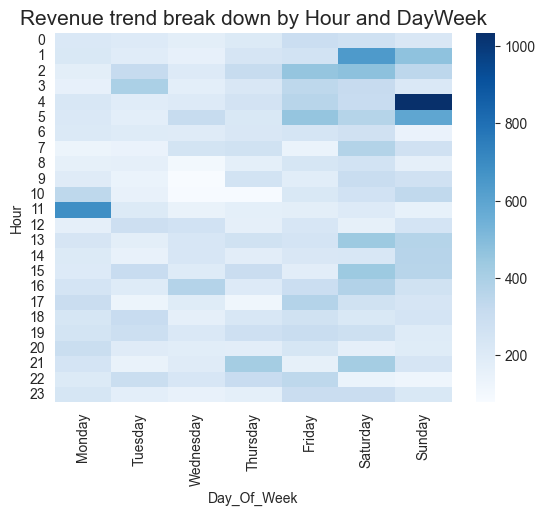

In [12]:
#Create Hour and DateWeek column and calculate rev
iap_purchase_drop['Hour'] = pd.to_datetime(iap_purchase_drop['time']).dt.hour
iap_purchase_drop['Day_Of_Week'] = iap_purchase_drop['time'].dt.day_name()
heat_map_rev = iap_purchase_drop.groupby(['Hour', 'Day_Of_Week'])['iap_price_usd_cents'].sum().unstack()
new_order = [1,5,6,4,0,2,3]
#Visualize data
heat_map_rev = heat_map_rev[heat_map_rev.columns[new_order]]
heat_vis=sns.heatmap(heat_map_rev,cmap='Blues')
heat_vis.set_title('Revenue trend break down by Hour and DayWeek',fontsize=15)
plt.show()

Analyze the geographic split of the revenue and the users (Join Table then Extract to Excel to visualize on Power BI)

In [13]:
# Geo=Overview_table_raw.groupby(['country_code','Month'],as_index=False).agg(
#          Revenue=('iap_price_usd_cents', 'sum'),
#          AU=('account_id', 'nunique'),
#      )
# with pd.ExcelWriter('output1.xlsx') as writer:Geo.to_excel(writer, sheet_name='Sheet1',index=False)


**Task1:**

LTV of player's first week in game

In [14]:
#Adjust created_time column in account_date_session, iap_purchase
# iap_purchase['created_time']=[iap_purchase['created_time'][i] for i in range(len(iap_purchase))]
iap_purchase['created_time']=[iap_purchase.created_time[i][:10] for i in range(len(iap_purchase))]
iap_purchase['created_time']=[dt.datetime.strptime(iap_purchase.created_time[i],'%Y-%m-%d') for i in range(len(iap_purchase))]
account_date_session['Months']=[pd.to_datetime(account_date_session.date[i]).month for i in range(len(account_date_session))]
account_date_session['Days']=[pd.to_datetime(account_date_session.date[i]).day for i in range(len(account_date_session))]
# account_date_session['created_time']=[account_date_session.date[i][:19] for i in range(len(account_date_session))]
# account_date_session['created_time']=[dt.datetime.strptime(account_date_session.date[i],'%Y-%m-%d %H:%M:%S') for i in range(len(account_date_session))]



# # #Create a table with contain min months of each user in account_date_session
# df_min_month=account_date_session.groupby('account_id').Months.agg([min])
# df_min_month.rename(columns={'min':'min_months'},inplace=True)
# df_min_month.reset_index(inplace=True)

# # #Chosing customer first week play:

# df_fw_temp=pd.merge(account_date_session,df_min_month,on='account_id',how='left')
# df_fw_temp1=df_fw_temp.groupby(['account_id','min_months']).Days.agg([min])
# df_fw_temp1.rename(columns={'min':'Days','min_months':'Months'},inplace=True)
# df_fw_temp2=pd.merge(account_date_session,df_fw_temp1,how='left',on=['account_id','Months','Days'])





# # #Chosing customer first week pay:

# df_fw_pay=pd.merge(df_fw_temp2,iap_purchase,on='acount_id',how='left')
# df_fw_pay=df_fw_pay[(df_fw_pay['created_time']<=df_fw_temp2['created_time']+dt.timedelta(days=7))&(df_fw_pay['created_time']>=df_fw_temp2['created_time'])]

# #Percent customer paying on first week

# percent_first_week=round(100*len(pd.unique(df_fw_pay))/len(pd.unique(account_date_session),2))


In [15]:
account_date_session['created_time']=[account_date_session.date[i][:10] for i in range(len(account_date_session))]
account_date_session['created_time']=[dt.datetime.strptime(account_date_session.date[i],'%Y-%m-%d') for i in range(len(account_date_session))]

In [22]:
account_date_session.rename(columns={'Months':'Month'},inplace=True)

iap_purchase['Months']=[pd.to_datetime(iap_purchase.created_time[i]).month for i in range(len(iap_purchase))]
iap_purchase['Days']=[pd.to_datetime(iap_purchase.created_time[i]).day for i in range(len(iap_purchase))]


# # # #Create a table with contain min months of each user in account_date_session
df_min_month=account_date_session.groupby('account_id').Month.agg([min])
df_min_month.reset_index(inplace=True)
df_min_month.rename(columns={'min':'min_months'},inplace=True)

# # #Chosing customer first week play:

df_fw_temp=pd.merge(account_date_session,df_min_month,on='account_id',how='left')
df_fw_temp1=df_fw_temp.groupby(['account_id','min_months']).Days.agg([min])
df_fw_temp1.reset_index(inplace=True)
df_fw_temp1.rename(columns={'min':'Days','min_months':'Months'},inplace=True)
account_date_session.rename(columns={'Month':'Months'},inplace=True)
df_fw_temp1
df_fw_temp2=pd.merge(account_date_session,df_fw_temp1,how='left',on=['account_id','Months','Days'])

df_fw_pay=pd.merge(iap_purchase,df_fw_temp2,on=['account_id','Months'],how='left')
df_fw_pay=df_fw_pay[(df_fw_pay['created_time_x']<=df_fw_pay['created_time_y']+dt.timedelta(days=7))&(df_fw_pay['created_time_x']>=df_fw_pay['created_time_y'])]

#Percent customer paying on first week
percent_1st_week=round(100*len(pd.unique(df_fw_pay['account_id']))/len(pd.unique(account_date_session['account_id'])),2)
print(percent_1st_week)


1.38


C:\Users\Administrator\AppData\Local\Temp\ipykernel_17468\2911269426.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LTV_on_months = LTV_on_months.append({'Months': i, 'LTV': ltv, 'Customer_Value': customer_value, 'Churn_rate': churn_rate}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17468\2911269426.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LTV_on_months = LTV_on_months.append({'Months': i, 'LTV': ltv, 'Customer_Value': customer_value, 'Churn_rate': churn_rate}, ignore_index=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17468\2911269426.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  LTV_on_months = LTV_on_months.append({'Months': i, 'LTV': ltv, 'Customer_Value': 

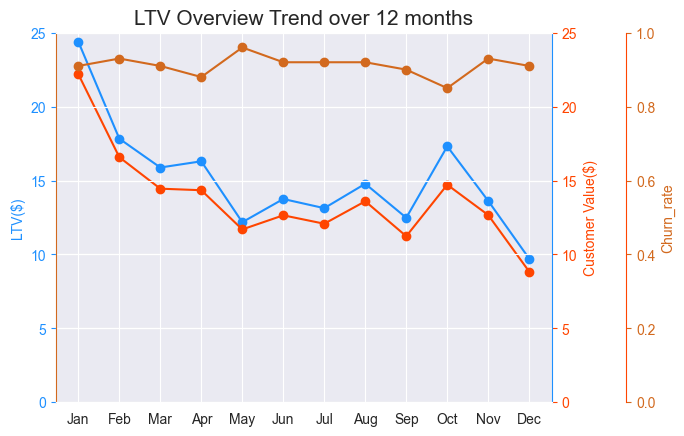

In [26]:
 #LTV for each months:
iap_purchase_drop['days']=pd.to_datetime(iap_purchase_drop['time']).dt.day
def LTV(iap_purchase_drop,months):
    LTV_month_temp=iap_purchase_drop[iap_purchase_drop.Month==months][['account_id','iap_price_usd_cents','days']]
    APV=round(sum(LTV_month_temp.iap_price_usd_cents)/len(LTV_month_temp),2)
    APFR=round(len(LTV_month_temp)/len(pd.unique(LTV_month_temp.account_id)),2)
    Customer_value=APV*APFR
    
    #Calculate Churn_rate
    LTV_month_temp1=LTV_month_temp[LTV_month_temp.days<=max(LTV_month_temp.days)-1].drop_duplicates(subset='account_id')
    LTV_month_temp2=LTV_month_temp[LTV_month_temp.days==max(LTV_month_temp.days)].drop_duplicates(subset='account_id')
    LTV_month_temp3=pd.merge(LTV_month_temp1,LTV_month_temp2,on='account_id',how='left')
    Churn_rate=round(LTV_month_temp3.days_y.isna().sum()/len(pd.unique(LTV_month_temp.account_id)),2)
    #Calculate LTV
    
    LTV=round(Customer_value/Churn_rate,2)
    
    return(LTV,Customer_value,Churn_rate)


# Create a DataFrame LTV_on_months
LTV_on_months = pd.DataFrame(columns=['Months', 'LTV', 'Customer_Value', 'Churn_rate'])
for i in range(1,13):
    ltv, customer_value, churn_rate = LTV(iap_purchase_drop, i)
    LTV_on_months = LTV_on_months.append({'Months': i, 'LTV': ltv, 'Customer_Value': customer_value, 'Churn_rate': churn_rate}, ignore_index=True)
LTV_on_months['Months'] = pd.to_datetime(LTV_on_months['Months'], format='%m').dt.month_name().str.slice(stop=3)

LTV_on_months   
#Plot line graph on LTV_on_months
sns.set_style('darkgrid')
fig, ax1 = plt.subplots()

ax1.plot(LTV_on_months.Months,LTV_on_months.LTV,color="#1E90FF",marker='o')

ax2 = ax1.twinx()
ax2.plot(LTV_on_months.Months,LTV_on_months.Customer_Value,color="#FF4500",marker='o')

ax3 = ax1.twinx()
ax3.plot(LTV_on_months.Months,LTV_on_months.Churn_rate,color="#D2691E",marker='o')
ax3.spines['right'].set_position(('axes',1.15))

ax1.set(ylim=(0, 25))
ax2.set(ylim=(0, 25))
ax3.set(ylim=(0, 1))

ax1.set_ylabel("LTV($)",color="#1E90FF")
ax2.set_ylabel("Customer Value($)",color="#FF4500")
ax3.set_ylabel("Churn_rate",color="#D2691E")

ax1.tick_params(axis='y',colors="#1E90FF")
ax2.tick_params(axis='y',colors="#FF4500")
ax3.tick_params(axis='y',colors="#D2691E")

ax2.spines['right'].set_color("#1E90FF")
ax3.spines['right'].set_color("#FF4500")
ax3.spines['left'].set_color("#D2691E")

ax1.set_title('LTV Overview Trend over 12 months',fontsize=15)

plt.show()


**Task2:**

Sale overviews and product analysis

Extract iap_purchase table to csv to visualize on Power BI

In [19]:
# with pd.ExcelWriter('output2.xlsx') as writer:iap_purchase_drop.to_excel(writer, sheet_name='Sheet1',index=False)

Time per session and Number of Transaction:

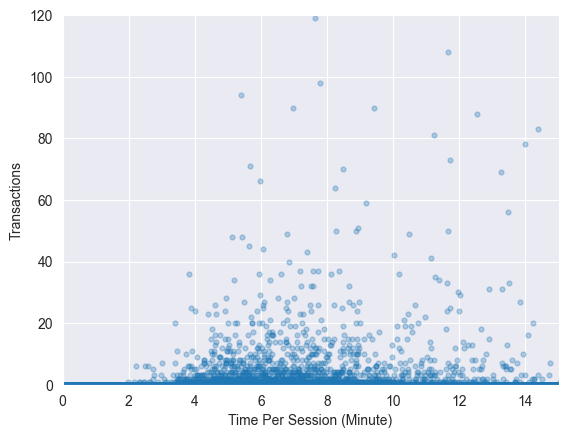

In [27]:

#Calculate_Time_per_Session
Overview_table_time_per_ss_user = (Overview_table_raw.groupby(['account_id'],as_index=False).apply(time_per_ss))
Overview_table_time_per_ss_user = Overview_table_time_per_ss_user.rename(columns={None: 'time_per_session'})
Overview_table_time_per_ss_user['time_per_session']=(Overview_table_time_per_ss_user['time_per_session']/60).round(2)

#Calculate_Transactions
iap_purchase_drop_count_gbu=(iap_purchase_drop.groupby(['account_id'],as_index=False))['iap_price_usd_cents'].count()
Transaction_and_time_per_ss=pd.merge(Overview_table_time_per_ss_user, iap_purchase_drop_count_gbu[['account_id','iap_price_usd_cents']], how='left', on=['account_id'])
Transaction_and_time_per_ss['iap_price_usd_cents'] = Transaction_and_time_per_ss['iap_price_usd_cents'].fillna(0)
Transaction_and_time_per_ss

#Visualize data:
plt.scatter(Transaction_and_time_per_ss.time_per_session, Transaction_and_time_per_ss.iap_price_usd_cents, alpha=0.3, s=12) 

plt.xlim(0, 15)
plt.ylim(0, 120)

plt.xlabel('Time Per Session (Minute)')
plt.ylabel('Transactions')
plt.show()